# RTED-TDS Co-Sim

Authored by [Jinning Wang](https://scholar.google.com/citations?user=Wr7nQZAAAAAJ&hl=en&oi=ao), recently updated on 06/06/2022.

This notebook is used to implement the Co-Simulation of Real Time Economic Dispatch (RTED) and Time-Domain Simulation (TDS).
In the RTED, SFR is considered. In the TDS, AGC is implemented with an equation defined PI controller.

RTED is seperated into two DCOPF and ACOPF: 1) DCOPF with SFR is solved in gurobipy, which is packaged into the class ``rted`` in the file ``rted.py``. 2) ACOPF is solved in pandapower.

Class ``rted2`` has attributes ``mdl`` which is a gurobipy model.

Table of contents:
- Import case: import ADNES case
- Load synthetic: build load curve as a scalar
- Setup ``ssp`` and ``ssd``
- Prepare: define some functions
- Define param: define RTED loop parameters
- Loop: Co-Sim loop

List of major vars:

- ``ssa`` ANDES system
- ``ssp`` pandapower net
- ``ssd`` DCOPF instance
- ``sse`` EV aggregator

Things need to be done when switching to other cases:
- Assign generator cost data. The rows of gen_cost array should be the same with the length of ``ssp.gen``
  including those uncontrollable ones, so the DCOPF model can build correctly.
- Define generator controllability of ``ssp``, all generators are controllable by default
- Define power system data: SFR cost, ramp limit (5-min-based)
- Define generator type in ``ssd``, default as type I. For type I generator, generator limtis have impact on both generation and SFR capacity. For yype II generator, SFR capacity is determined by param ``pru_max`` and ``prd_max``

Environment requirements:
- ANDES (1.6.3+)
- pandapower (2.7.0 is tested to be function correctly)
- gurobipy
- pandas, matplotlib, scipy

## Import case

In [1]:
%run -i 'cosim_import.py'

1.7.2.post274.dev0+ge9bfbace
2.9.0


`caseH` is the start time [H] of the co-simulation, now 10 and 18 are supported.

In [2]:
caseH = 18
%run -i 'cosim_setup_andes.py'

EVA: ts=18[H], 50000 EVs, Total Q=1250.86 MWh
Online 14481, Q=361.83 MWh, SoC=0.7687
Power(MW): Pt=-39.9433, Pc=-39.9433, Pd=-0.0
Ctrl: 0=7778; 1=6703; 
EVA: Load A from Aest.csv.
Working directory: "/home/jwang175/andes/jwang/notes2"
> Loaded config from file "/home/jwang175/.andes/andes.rc"
> Loaded generated Python code in "/home/jwang175/.andes/pycode".
Generated code for <PQ> is stale.
Numerical code generation (rapid incremental mode) started...


Generating code for 1 models on 6 processes.


Saved generated pycode to "/home/jwang175/.andes/pycode"
> Reloaded generated Python code of module "pycode".
Generated numerical code for 1 models in 0.3363 seconds.
Parsing input file "/home/jwang175/andes/jwang/case/ieee39_ev2.xlsx"...
Input file parsed in 0.1640 seconds.
ACEc <1> added BusFreq <BusFreq_11> linked to bus <1>
System internal structure set up in 0.0563 seconds.


## Load synthetic

Create load data ``d_syn``, which is a ``DataFrame`` that have three columns: ``time``, ``s10``, ``h10``. ``time`` is by seconds, ``s10`` is scalar load.

ANDES total load is: 58.564 p.u.


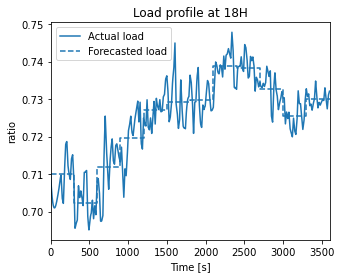

In [3]:
%run -i 'cosim_loadsyn.py'

## Setup ``ssp`` and ``ssd``

Convert ``ssa`` to pandapower net ``ssp``, add generator cost

The input cost array follow the matpower/pypower format, now only poly_cost is supported

In [4]:
%run -i 'cosim_setup_dispatch.py'

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.1182 seconds.
0: |F(x)| = 7.561249598
1: |F(x)| = 2.917108301
2: |F(x)| = 0.1313043343
3: |F(x)| = 0.0003572409148
4: |F(x)| = 4.286947242e-09
Converged in 5 iterations in 0.0092 seconds.
Power flow results are consistent. Conversion is successful.


Restricted license - for non-production use only - expires 2023-10-25


-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0174 seconds.
0: |F(x)| = 7.561249598
1: |F(x)| = 2.917108301
2: |F(x)| = 0.1313043343
3: |F(x)| = 0.0003572409148
4: |F(x)| = 4.286947242e-09
Converged in 5 iterations in 0.0138 seconds.
Power flow results are consistent. Conversion is successful.
GSF is consistent.
RTED GB model is loaded.
RTED removed Constrs: ['pgmax', 'pgmin', 'sfru', 'sfrd', 'rampu', 'rampd']
RTED: total cost=1190.445


pp cost=119076.9432479764, gb cost=1190.4454649077431


In [5]:
ppres

,p_mw,q_mvar,va_degree,vm_pu,p_mw(GB)
0,974.962791,90.172034,13.477847,1.0,1040.000000
1,645.999998,310.953290,5.351632,1.0,646.000000
2,724.999999,148.814082,9.037905,1.0,725.000000
3,651.999999,129.657714,3.920546,1.0,652.000000
4,200.000002,145.038662,-3.697230,1.0,200.000000
5,686.999998,225.095690,9.288003,1.0,687.000000
6,480.780560,60.466680,10.484205,1.0,232.000000
7,225.600001,-26.007725,5.484658,1.0,409.343346
8,864.999999,115.299174,14.197814,1.0,865.000000
9,-39.943346,0.000000,14.197814,1.0,-39.943346


## Prepare

### Make link table

In [6]:
%run -i 'cosim_linktable.py'

In [7]:
ssa_key2

,stg_name,stg_u,stg_idx,bus_idx,dg_idx,rg_idx,syg_idx,exc_idx,gov_idx,bus_name,gammap,gammaq,gen_pp,ctrl
0,PV_1,1.0,PV_1,30,False,False,GENROU_1,IEEEX1_1,TGOV1_1,GEN30,1.0,1.0,0,True
1,PV_2,1.0,PV_2,31,False,False,GENROU_2,IEEEX1_2,TGOV1_2,GEN31,1.0,1.0,1,True
2,PV_3,1.0,PV_3,32,False,False,GENROU_3,IEEEX1_3,TGOV1_3,GEN32,1.0,1.0,2,True
3,PV_4,1.0,PV_4,33,False,False,GENROU_4,IEEEX1_4,TGOV1_4,GEN33,1.0,1.0,3,True
4,PV_5,1.0,PV_5,34,False,False,GENROU_5,IEEEX1_5,TGOV1_5,GEN34,1.0,1.0,4,True
5,PV_6,1.0,PV_6,35,False,False,GENROU_6,IEEEX1_6,TGOV1_6,GEN35,1.0,1.0,5,True
6,PV_7,1.0,PV_7,36,False,False,GENROU_7,IEEEX1_7,TGOV1_7,GEN36,1.0,1.0,6,True
7,PV_8,1.0,PV_8,37,False,False,GENROU_8,IEEEX1_8,TGOV1_8,GEN37,1.0,1.0,7,True
8,PV_9,1.0,PV_9,38,False,False,GENROU_9,IEEEX1_9,TGOV1_9,GEN38,1.0,1.0,8,True
9,Slack_10,1.0,Slack_10,39,False,False,GENROU_10,IEEEX1_10,TGOV1_10,GEN39,1.0,1.0,10,True


## Loop

In the loop, there are mainly X parts:

- interval RTED: run DCOPF (``ssd.mdl``), run ACOPF(``ssp``), 

- interval AGC: do AGC, do dispatch with smooth setpoints

- interval PQ: alter load, run TDS(``ssa.TDS``)

Notes:

- The setpoints for DG are coded but not verified yet.

- After the development of ANDES control room, the dispatch and AGC part can be refactored.

- interface variables: ``DG.pmx``: DPV profile, ``DG.pref0``: setpoints, ``DG.pext0``: AGC

- ACOPF in pandapower considered generator limtis of ramping and SFR reserve

In [8]:
# Change ``rru``, ``rrd``, ``rsfr``, ``t_total`` for necessary.
t_total = 3600

rru, rrd, rsfr = 1.0, 1.0, 0.03

# Define functions and constants used in loop
%run -i 'cosim_const.py'

Check convergence

In [9]:
%run -i 'cosim_bmain.py'

RTED removed Constrs: ['rampu', 'rampd']


RTED not solved:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
They run into: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Loop

In [10]:
%run -i 'cosim_main.py'

RTED GB model is loaded.
RTED removed Constrs: ['rampu', 'rampd']
RTED is solved.
RTED: total cost=845.315
ACOPF failed, DCOPF is used instead.
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0191 seconds.
0: |F(x)| = 7.806456207
1: |F(x)| = 3.119688107
2: |F(x)| = 0.1723424202
3: |F(x)| = 0.02640150009
4: |F(x)| = 0.0264015
5: |F(x)| = 0.0264015
6: |F(x)| = 0.0264015
7: |F(x)| = 0.0264015
8: |F(x)| = 0.0264015
9: |F(x)| = 0.0264015
10: |F(x)| = 0.0264015
11: |F(x)| = 0.0264015
12: |F(x)| = 0.0264015
13: |F(x)| = 0.0264015
14: |F(x)| = 0.0264015
15: |F(x)| = 0.0264015
16: |F(x)| = 0.0264015
17: |F(x)| = 0.0264015
18: |F(x)| = 0.0264015
19: |F(x)| = 0.0264015
20: |F(x)| = 0.0264015
21: |F(x)| = 0.0264015
22: |F(x)| =

TypeError: object of type 'NoneType' has no len()

In [11]:
ssa.exit_code

1

In [12]:
# ssa.TDS.save_output()

AttributeError: 'NoneType' object has no attribute 'plot'

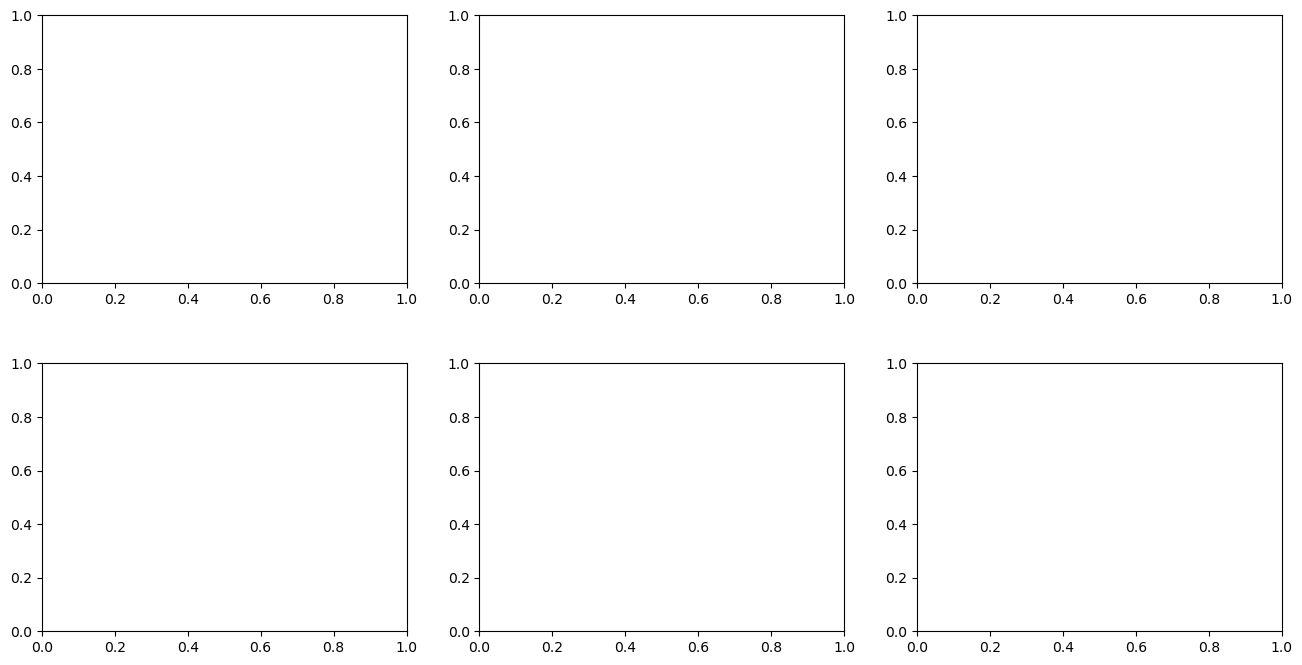

In [13]:
%run -i 'cosim_plot.py'

/home/jwang175/andes/jwang/notes2/ev_ssm.py:485: UserWarning: Attempting to set identical left == right == 18 results in singular transformations; automatically expanding.
  ax.set_xlim(self.tss[0], self.tss[-1])


(<Figure size 600x300 with 1 Axes>,
 <AxesSubplot:title={'center':'AGC response'}, xlabel='Time [H]', ylabel='Power (MW)'>)

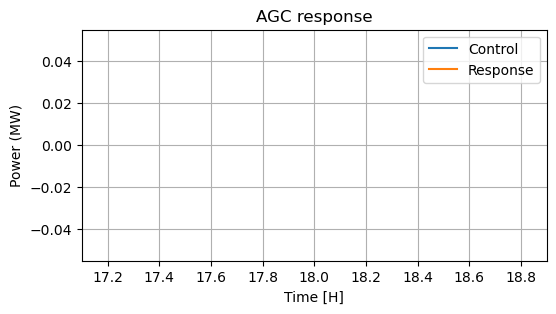

In [14]:
sse.plot_agc()

In [15]:
# Complement AGC table
agc_smooth = pd.DataFrame(np.repeat(agc_in[list(np.arange(0, t_total, 4))].values, 4, axis=1),
                          columns=list(np.arange(0, t_total, 1)))

# Record output
sse_out = pd.DataFrame()
sse_out['time'] = sse.tss
sse_out['agc'] = agc_smooth.iloc[10]  # AGC input to EV
sse_out['Pr'] = sse.Prl
sse_out['Prc'] = sse.Prcl
sse_out.to_csv('sse_out.csv', index=False)

In [16]:
soc_plot = ev_soc[ev_agc.abs().sum(axis=1) > 0].reset_index(drop=True)
soc_plot = soc_plot[list(range(end_time+1))]

fig_soc, ax_soc = plt.subplots(figsize=(5, 4))
for i in range(soc_plot.shape[0]):
    ax_soc.plot(range(end_time+1), soc_plot.iloc[i])
ax_soc.set_xlabel('Time [s]')
ax_soc.set_ylabel('SOC [%]')
ax_soc.set_title('AGC EVs SOC')
ax_soc.set_xlim([0, end_time])

AttributeError: 'numpy.ndarray' object has no attribute 'abs'

In [ ]:
sse.plot(style='ieee')